In [1]:
import geopandas as gpd
import pandas as pd
import os
import glob
import requests
import zipfile
import matplotlib.pyplot as plt
import overpass
from shapely.geometry import Point, MultiPoint
from fuzzywuzzy import process

/Users/sarategoni/Documents/tesi_rifugi/alpinehutsustainability/venv/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
import warnings
warnings.simplefilter("ignore")

# Cadastral data
## Download 
Source: https://catastotn.tndigit.it/scarico-catasto-geometrico/it/index.html

In [ ]:
download_url = "https://catastotn.tndigit.it/export_semestrale_VL_PUBB/IDR0020240701_TIPOCATSH_CCXXX.zip"
url_csv = "../data/huts/catasto_rifugi.csv"

cadastre_huts_df = pd.read_csv(url_csv)
codici_catastali = cadastre_huts_df.codice_comune_catastale.unique()
codici_catastali

In [4]:
# Request cadastral data for municipalities containing huts
gdflist = []
for codice in codici_catastali:
    codice = str(codice).zfill(3).replace(".0","")
    url = download_url.replace("XXX",codice)
    response = requests.get(url)
    # Elenca i nomi dei file che vuoi estrarre
    files_to_extract = []
    suffix = "_vl_uniqueparcel_poly"
    suffix = "_vl_parcel_poly"
    files_to_extract.append(codice + suffix + ".prj")
    files_to_extract.append(codice + suffix + ".shp")
    files_to_extract.append(codice + suffix + ".shx")
    files_to_extract.append(codice + suffix + ".dbf")
    if response.status_code == 200:
        with open("file.zip", "wb") as file:
            file.write(response.content)
        with zipfile.ZipFile("file.zip", "r") as zip_ref:
            for file_name in zip_ref.namelist():
                if file_name in files_to_extract:
                    zip_ref.extract(file_name)
        gdf = gpd.read_file(codice + suffix + ".shp")
        crs = gdf.crs
        gdflist.append(gdf)
        os.remove("file.zip")
        for shp in files_to_extract:
            os.remove(shp)
parcels = gpd.GeoDataFrame(pd.concat(gdflist, ignore_index=True), crs=crs)

In [ ]:
parcels

In [6]:
parcels = parcels.to_crs(epsg=4326)

In [7]:
#parcels.plot()

I only need the parcels of the huts, which I know the codes (PT_CODE) from ../data/huts/catasto_rifugi.csv, so I filter and save as a new dataframe (polygons_gdf)

In [21]:
polygons_gdf = gpd.GeoDataFrame()
for idx, rif in cadastre_huts_df.iterrows():
  rif_particella = parcels[(parcels['PT_CODE'] == rif['codice_part_ed']) & (parcels['PT_CCAT'] == rif['codice_comune_catastale'])]
  if rif['rifugio_nome'] == 'Spruggio - "G.Tonini"':
    continue
  if not rif_particella.empty:
    polygons_gdf = pd.concat([polygons_gdf, rif_particella])
  else:
    print(rif['rifugio_nome'], "not found!") 

Each hut is registered with multiple geometries for the same parcel code, we can plot them together to see the total area of the hut:

In [ ]:
# Rifugio Dorigoni
polygons_gdf[(polygons_gdf['PT_CODE'] == "5239/2") & (polygons_gdf['PT_CCAT'] == 300)].plot(column='PT_TYPE', legend=True)

In [25]:
# Save in a file (optional)
polygons_gdf.to_file("../data/huts/huts_parcels_downloaded.geojson")

## Hut names
I add hut names for interpretability. I use standardized names from the rifugio_nome column of cadastral information .csv

In [3]:
def standardize_name(name):
    ''' converts names to lowercase, strips leading and trailing whitespace, 
    and removes non-alphanumeric characters.
    '''
    return ''.join(e for e in name.lower().strip() if e.isalnum())

In [4]:
polygons_gdf = gpd.read_file('../data/huts/huts_parcels_downloaded.geojson')
polygons_gdf.head(5)

,PT_TYPE,PT_CODE,PT_CCAT,PT_FABB,PT_PUB,geometry
0,C,.690,404,N,YES,"POLYGON ((11.14523 45.82734, 11.14514 45.82733..."
1,P,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.14487 45.82735,..."
2,C,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.1448 45.82735, ..."
3,P,.1367,44,N,YES,"POLYGON ((10.89031 45.81007, 10.89031 45.81007..."
4,C,.1367,44,S,YES,"POLYGON ((10.89047 45.81044, 10.89031 45.81042..."


In [5]:
# Hut names in the cadastral data
cadastre_huts_df = pd.read_csv('../data/huts/catasto_rifugi.csv')
cadastre_huts_df.head(5)

,num,rifugio_nome,codice_comune_catastale,nome_comune_catastale,codice_part_ed,codice_part_f,note
0,1,"Alpe Pozza - ""V.Lancia""",404,TRAMBILENO,.690,-999,NaN
1,2,"Altissimo - ""D.Chiesa""",44,BRENTONICO,.1367,-999,NaN
2,3,Antermoia,223,MAZZIN,.329,-999,NaN
3,4,"Bindesi - ""P.Prati""",439,VILLAZZANO,.894,-999,NaN
4,5,"Bocca di Trat - ""N.Pernici""",307,RIVA,.1886,185/2,NaN


In [6]:
# Add names to each parcel using a merge with the .csv based on the 'PT_CODE'/codice_part_ed field
polygons_gdf = polygons_gdf.merge(cadastre_huts_df[['codice_part_ed', 'rifugio_nome']], 
                                  left_on='PT_CODE', right_on='codice_part_ed', how='left')
polygons_gdf = polygons_gdf.drop(columns=['codice_part_ed'])

# Create standardized names column
polygons_gdf['standard_name'] = polygons_gdf['rifugio_nome'].apply(standardize_name)

# Reorder columns 
cols = list(polygons_gdf.columns)
cols_to_move = ['rifugio_nome', 'standard_name']
# remove from the list the columns to move 
for col in cols_to_move:
    cols.remove(col)
# add the columns to move at the beginning
cols = cols_to_move + cols
# reorder the GeoDataFrame
polygons_gdf = polygons_gdf[cols]

polygons_gdf.head(5)

,rifugio_nome,standard_name,PT_TYPE,PT_CODE,PT_CCAT,PT_FABB,PT_PUB,geometry
0,"Alpe Pozza - ""V.Lancia""",alpepozzavlancia,C,.690,404,N,YES,"POLYGON ((11.14523 45.82734, 11.14514 45.82733..."
1,"Alpe Pozza - ""V.Lancia""",alpepozzavlancia,P,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.14487 45.82735,..."
2,"Alpe Pozza - ""V.Lancia""",alpepozzavlancia,C,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.1448 45.82735, ..."
3,"Altissimo - ""D.Chiesa""",altissimodchiesa,P,.1367,44,N,YES,"POLYGON ((10.89031 45.81007, 10.89031 45.81007..."
4,"Altissimo - ""D.Chiesa""",altissimodchiesa,C,.1367,44,S,YES,"POLYGON ((10.89047 45.81044, 10.89031 45.81042..."


## Centroids

In [7]:
# Group by 'rifugio_nome' and aggregate the geometries
grouped = polygons_gdf.dissolve(by='standard_name')

# Calculate the centroid for each group
grouped['centroid'] = grouped.geometry.centroid

# Merge the centroid back to the original polygons_gdf
polygons_gdf = polygons_gdf.merge(grouped[['centroid']], on='standard_name', how='left')

# Extract the x and y coordinates from the centroid (to keep only one geom column)
polygons_gdf['centroid_x'] = polygons_gdf['centroid'].x
polygons_gdf['centroid_y'] = polygons_gdf['centroid'].y

# Drop the original centroid column if no longer needed
polygons_gdf = polygons_gdf.drop(columns=['centroid'])

polygons_gdf.head(5)

,rifugio_nome,standard_name,PT_TYPE,PT_CODE,PT_CCAT,PT_FABB,PT_PUB,geometry,centroid_x,centroid_y
0,"Alpe Pozza - ""V.Lancia""",alpepozzavlancia,C,.690,404,N,YES,"POLYGON ((11.14523 45.82734, 11.14514 45.82733...",11.144756,45.827381
1,"Alpe Pozza - ""V.Lancia""",alpepozzavlancia,P,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.14487 45.82735,...",11.144756,45.827381
2,"Alpe Pozza - ""V.Lancia""",alpepozzavlancia,C,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.1448 45.82735, ...",11.144756,45.827381
3,"Altissimo - ""D.Chiesa""",altissimodchiesa,P,.1367,44,N,YES,"POLYGON ((10.89031 45.81007, 10.89031 45.81007...",10.890453,45.810334
4,"Altissimo - ""D.Chiesa""",altissimodchiesa,C,.1367,44,S,YES,"POLYGON ((10.89047 45.81044, 10.89031 45.81042...",10.890453,45.810334


In [8]:
# Save the final polygon GeoDataFrame
polygons_gdf.to_file('../data/huts/huts_polygons.geojson')

# SIAT points
In the siat dataset '../data/huts/Rifugi_e_bivacchi.shp' each hut is represented as a point. From a quick look in QGIS, many fall within the cadastral polygons, but others are slightly off (~200m). For these cases, by comparing with an ortophoto, the SIAT points seem to be more precise than the cadastral polygons. Therefore it could be appropriate to also consider those.

Using polygons or points will depend on the type of analysis. Therefore I store them in two separate GeoDataFrame and files, which can be accessed using the **standard_name** column (present in both).

I will now create a the **huts_points** GeoDataFrame from the SIAT points and some basic information from SAT stored in '../data/huts/categorie_rifugi'. Steps:

From siat_points_gdf:
- create standard_name column: perform a fuzzy matching on nome_strut
- get **quota, standard_name and geometry** columns

From categorie_df:
- get **categoria_CAISAT, categoria_PAT, posti_letto**

In [9]:
siat_points_gdf = gpd.read_file('../data/huts/Rifugi_e_bivacchi.shp')
polygons_gdf = gpd.read_file('../data/huts/huts_polygons.geojson')

# Set to same crs as polygons_gdf (epsg.4326)
siat_points_gdf = siat_points_gdf.to_crs(polygons_gdf.crs)
# remove bivacchi
siat_points_gdf = siat_points_gdf[siat_points_gdf['sottotipol'] != 'BIVACCO']

## Standardize names

In [10]:
siat_points_gdf['standard_name'] = siat_points_gdf['nome_strut'].apply(standardize_name)

missing_matches = {} # siat_name: polygon_name
# Iterate over each row in polygons_gdf['standard_name']
for polygon_name in polygons_gdf['standard_name'].unique(): 
    # Find the best match in siat_points_gdf['standard_name']
    match, score = process.extractOne(polygon_name, siat_points_gdf['standard_name'].values)
    if polygon_name == 'tosaetpedrotti': # problematicfor fuzzy matching
        match = 'tosatommasopedrotti'
    
    # Set a similarity threshold
    if score > 80 or polygon_name == 'tosaetpedrotti':
        # Replace the matched name in siat_points_gdf with the one from polygons_gdf
        #siat_points_gdf.loc[siat_points_gdf['standard_name'] == match, 'standard_name'] = polygon_name
        siat_points_gdf['standard_name'] = siat_points_gdf['standard_name'].replace(match, polygon_name)
        print(f"Match found: {match} -> {polygon_name}")
    else:
        missing_matches[match] = polygon_name
        print(f"No match found for {polygon_name}. Best match was {match}")


Match found: alpepozzavincenzolancia -> alpepozzavlancia
Match found: altissimodamianochiesa -> altissimodchiesa
Match found: antermoia -> antermoia
Match found: bindesipinoprati -> bindesipprati
Match found: boccaditratninopernici -> boccaditratnpernici
Match found: boe -> boè
Match found: carealtodanteongari -> carèaltodongari
Match found: casarota -> casarotalciola
Match found: cevedaleguidolarcher -> cevedaleglarcher
Match found: ciampedie -> ciampediè
Match found: cimadastaottonebrentari -> cimadastaobrentari
Match found: dodiciapostoliflligarbari -> xiiapostoliflligarbari
Match found: fftucketteqsella -> fftucketteqsella
Match found: finonchiofllifilzi -> finonchiofllifilzi
No match found for grostèggraffer. Best match was giorgiografferalgroste
Match found: mandroncittaditrento -> mandroncittàditrento
Match found: montecalinosanpietro -> montecalinosanpietro
Match found: monzonitorquatotaramelli -> monzonittaramelli
Match found: paludei -> paludei
Match found: peller -> peller
M

In [11]:
# Substitute the missing matches 
missing_matches

for siat_name, polygon_name in missing_matches.items():
    siat_points_gdf['standard_name'] = siat_points_gdf['standard_name'].replace(siat_name, polygon_name)

# Filter only for names contained in polygons_gdf (SAT's huts)
siat_points_gdf = siat_points_gdf[siat_points_gdf['standard_name'].isin(polygons_gdf['standard_name'])]
siat_points_gdf = siat_points_gdf.sort_values(by='standard_name', ascending=True)

# Check that all names in polygons are also in siat_points
[name for name in polygons_gdf.standard_name.unique() if name not in siat_points_gdf.standard_name.unique()]

## Merge with categories, etc.
Select desired columns from categorie.csv and siat_points_gdf  to create a single gdf and save it in ../data/huts/huts_points.geojson

In [13]:
# Load .csv
categorie_df = pd.read_csv('../data/huts/categorie_rifugi.csv')
categorie_df['standard_name'] = categorie_df['rifugio_nome'].apply(standardize_name)
categorie_df.head(5)

,rifugio_nome,categoria_CAISAT,categoria_PAT,quota,posti_letto,standard_name
0,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,alpepozzavlancia
1,"Altissimo - ""D.Chiesa""",C,Alp,2.060,35,altissimodchiesa
2,Antermoia,D,Alp,2.496,61,antermoia
3,"Bindesi - ""P.Prati""",A,Escurs,611.000,0,bindesipprati
4,"Bocca di Trat - ""N.Pernici""",C,Alp,1.600,28,boccaditratnpernici


In [14]:
# Merge
siat_points_gdf_merged = siat_points_gdf.merge(categorie_df, on='standard_name', how='left')

# Keep only relevant columns
siat_points_gdf_merged = siat_points_gdf_merged[['standard_name', 'nome_strut', 'categoria_CAISAT', 'categoria_PAT',
        'posti_letto', 'quota_x', 'geometry']]

# Column formatting
siat_points_gdf_merged = siat_points_gdf_merged.rename(columns={'quota_x': 'quota'})
siat_points_gdf_merged['quota'] = pd.to_numeric(siat_points_gdf_merged['quota'], errors='coerce')
siat_points_gdf_merged['posti_letto'] = pd.to_numeric(siat_points_gdf_merged['posti_letto'], errors='coerce')

# Set geometry from Multipoint to Point
def convert_multipoint_to_point(geometry):
    ''' convert MultiPoint to Point if it contains only one point '''
    if isinstance(geometry, MultiPoint) and len(geometry.geoms) == 1:
        return geometry.geoms[0]
    return geometry

# Apply the function to the geometry column of siat_points_gdf
siat_points_gdf_merged['geometry'] = siat_points_gdf_merged['geometry'].apply(convert_multipoint_to_point)

In [15]:
siat_points_gdf_merged.head(5)

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,geometry
0,alpepozzavlancia,"ALPE POZZA ""VINCENZO LANCIA""",C,Alp,50,1802,POINT (11.14471 45.82729)
1,altissimodchiesa,"ALTISSIMO ""DAMIANO CHIESA""",C,Alp,35,2060,POINT (10.89037 45.81038)
2,antermoia,ANTERMOIA,D,Alp,61,2496,POINT (11.66391 46.47703)
3,bindesipprati,"BINDESI ""PINO PRATI""",A,Escurs,0,618,POINT (11.15392 46.03619)
4,boccaditratnpernici,"BOCCA DI TRAT ""NINO PERNICI""",C,Alp,28,1601,POINT (10.76868 45.92663)


In [16]:
# Save to file
siat_points_gdf_merged.to_file('../data/huts/huts_points.geojson')

--------------

# Plot: Centroids VS SIAT points

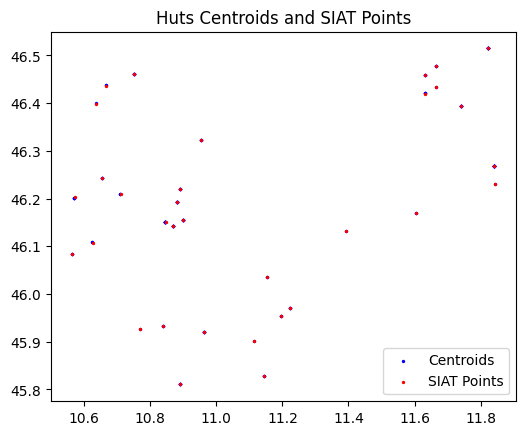

In [18]:
polygons_gdf = gpd.read_file('../data/huts/huts_polygons.geojson')
points_gdf = gpd.read_file('../data/huts/huts_points.geojson')

# Recover the centroid points from the x and y columns
polygons_gdf['centroid'] = polygons_gdf.apply(lambda row: Point(row['centroid_x'], row['centroid_y']), axis=1)
# Create a GeoDataFrame for centroids
centroids_gdf = gpd.GeoDataFrame(polygons_gdf[['standard_name', 'centroid']], geometry='centroid')

# Plotting
fig, ax = plt.subplots()
centroids_gdf.plot(ax=ax, color='blue', markersize=2, label='Centroids')
points_gdf.plot(ax=ax, color='red', marker='o', markersize=2, label='SIAT Points')
plt.title('Huts Centroids and SIAT Points')
plt.legend()
plt.show()

# Delete centroid column (extra geometry)
polygons_gdf = polygons_gdf.drop(columns=['centroid'])

# Data Exploration


Categoria CAISAT

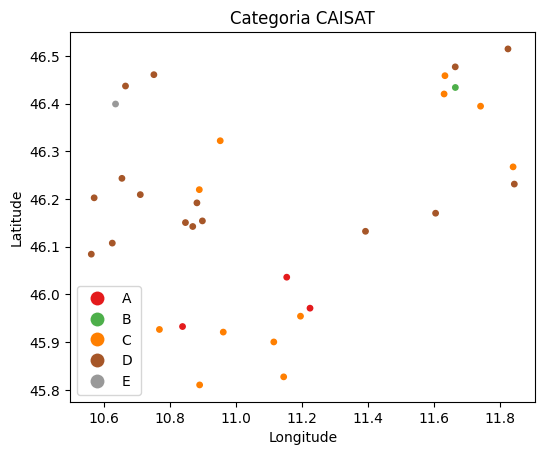

In [22]:
# Plotting
fig, ax = plt.subplots()
points_gdf.plot(column='categoria_CAISAT', ax=ax, markersize=15, legend=True, cmap='Set1')
ax.set_title('Categoria CAISAT')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [23]:
points_gdf['categoria_CAISAT'].value_counts()

categoria_CAISAT
D     16
C     12
A      3
B      1
E      1
Name: count, dtype: int64

Categoria PAT

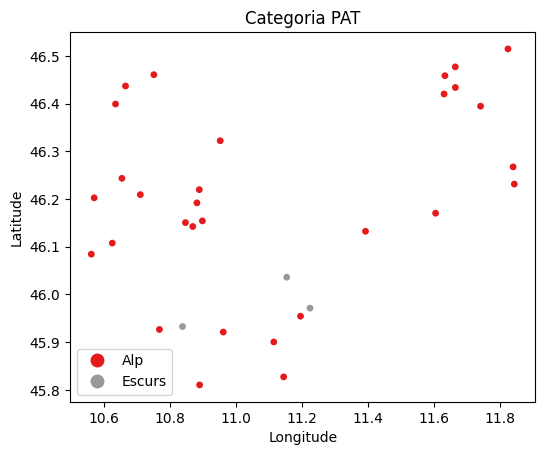

In [24]:
# Plotting
fig, ax = plt.subplots()
points_gdf.plot(column='categoria_PAT', ax=ax, markersize=15, legend=True, cmap='Set1')
ax.set_title('Categoria PAT')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

Elevation

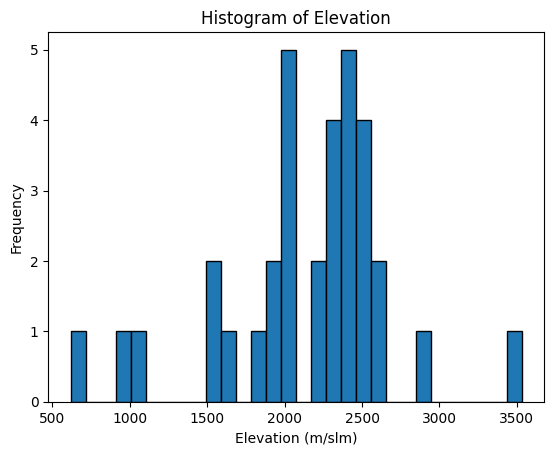

In [28]:
quota_data = points_gdf['quota']

# Plot the histogram
plt.figure()
plt.hist(quota_data, bins=30, edgecolor='black')
plt.title('Histogram of Elevation')
plt.xlabel('Elevation (m/slm)')
plt.ylabel('Frequency')
plt.show()